In [25]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import seaborn as sns, pandas as pd, numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures, PowerTransformer
from sklearn.metrics import make_scorer,f1_score,accuracy_score,confusion_matrix,roc_auc_score,roc_curve, recall_score,precision_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, NuSVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, kruskal,chi2_contingency

# from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE 
# from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours, NeighbourhoodCleaningRule, OneSidedSelection



def minha_metrica(y_true, y_pred):
    threshold = 0.5  # Defina o threshold desejado
    

    # Calcule o true positive rate para o threshold dado
    tp = np.sum((y_true == 1) & (y_pred >= threshold))
    fn = np.sum((y_true == 1) & (y_pred < threshold))
    tpr = tp / (tp + fn)

    # Calcule o true negative rate para o threshold dado
    tn = np.sum((y_true == 0) & (y_pred < threshold))
    fp = np.sum((y_true == 0) & (y_pred >= threshold))
    tnr = tn / (tn + fp)

    # Calcule o produto dos passos 1 e 2
    product = tpr * tnr

    # Retorne a raiz quadrada do passo 3
    return np.sqrt(product)

def minha_metrica_c(y_true, y_pred,threshold = 0.5):
    

    # Calcule o true positive rate para o threshold dado
    tp = np.sum((y_true == 1) & (y_pred >= threshold))
    fn = np.sum((y_true == 1) & (y_pred < threshold))
    tpr = tp / (tp + fn)

    # Calcule o true negative rate para o threshold dado
    tn = np.sum((y_true == 0) & (y_pred < threshold))
    fp = np.sum((y_true == 0) & (y_pred >= threshold))
    tnr = tn / (tn + fp)

    # Calcule o produto dos passos 1 e 2
    product = tpr * tnr

    # Retorne a raiz quadrada do passo 3
    return np.sqrt(product)


In [2]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv", sep=',')
data.dropna(inplace=True)
target = 'stroke'

le = LabelEncoder()
for cl in data.columns:
    if data[cl].dtypes==np.object0:
        data[cl] = le.fit_transform(data[cl])
data.dtypes.value_counts()

clm =  data.columns
for cl in data.columns[1:-1]:
    if data[cl].dtypes==np.int64:
        contingency_table = pd.crosstab(data[cl], data['stroke'])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        print(f'categorical: {cl}, p: {p}, teste: {chi2}')
    else:
        groups = []
        for category, group_data in data.groupby(cl)['stroke']:
            groups.append(group_data)
        f_statistic, p_value = kruskal(*groups)
        print(f'continuous: {cl}, p: {p_value}, teste: {f_statistic}')


X, y = data.drop([target,'gender','Residence_type','bmi','id'], axis=1), data[target]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y, random_state=42)

# balancear = SMOTE()
# X_resampled, y_resampled = balancear.fit_resample(X_train, y_train)
my_scorer = make_scorer(roc_auc_score,greater_is_better=True)


categorical: gender, p: 0.8700408526403285, teste: 0.27843022275621393
continuous: age, p: 2.0127967611790093e-42, teste: 435.341321938475
categorical: hypertension, p: 6.033751208728256e-23, teste: 97.2749949311716
categorical: heart_disease, p: 2.0677783295228626e-21, teste: 90.2795595563918
categorical: ever_married, p: 3.1283412849388787e-13, teste: 53.12593819801626
categorical: work_type, p: 1.7055668658884947e-08, teste: 41.95353832836521
categorical: Residence_type, p: 0.7249227580411615, teste: 0.12382469623434333
continuous: avg_glucose_level, p: 0.012079723656240942, teste: 4051.5811473073345
continuous: bmi, p: 0.6425418216175964, teste: 405.88370500936884
categorical: smoking_status, p: 1.2522021032753853e-07, teste: 34.9434924570628


In [ ]:
sns.countplot(data=data, x=target)


Ponto mais próximo do canto superior esquerdo:
FPR: 0.23590425531914894
TPR: 0.8143712574850299
Limiar: -2.9618182757143363
--minha métrica--
0.7888330700691402 0.7017130580269054
--acuracia--
0.7662337662337663 0.7606924643584522
--confusion matriz--
[[720 220]
 [ 15  27]]


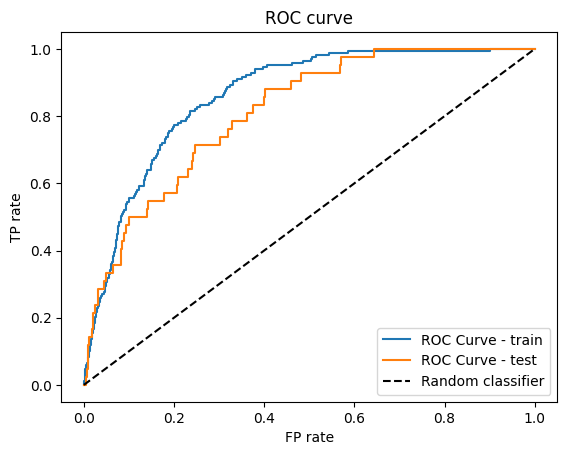

In [9]:
pipe = Pipeline([('escala',MinMaxScaler()),('modelo', LogisticRegression(penalty='l2',max_iter=1000000))])


bests = pipe.fit(X_train, y_train)


y_pred_test = bests.decision_function(X_test)
y_pred_train = bests.decision_function(X_train)

fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
distances = (fpr - 0)**2 + (tpr - 1)**2
index = distances.argmin()
best_threshold = thresholds[index]
fprts, tprts, thresholdsts = roc_curve(y_test, y_pred_test)
print("Ponto mais próximo do canto superior esquerdo:")
print("FPR:", fpr[index])
print("TPR:", tpr[index])
print("Limiar:", best_threshold)


corte = best_threshold
print("--minha métrica--")
print(minha_metrica_c(y_train,y_pred_train,corte),minha_metrica_c(y_test,y_pred_test,corte))
print("--acuracia--")
print(accuracy_score(y_train,y_pred_train>=corte),accuracy_score(y_test,y_pred_test>=corte))
print("--confusion matriz--")
print(confusion_matrix(y_pred=y_pred_test>=corte,y_true=y_test))

plt.plot(fpr, tpr, label='ROC Curve - train')
plt.plot(fprts, tprts, label='ROC Curve - test')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

--melhor escore no cv--
0.7897965032778324
--parâmetros de melhor escore no cv--
{'modelo__C': 0.07742636826811278}
Ponto mais próximo do canto superior esquerdo:
FPR: 0.225531914893617
TPR: 0.8143712574850299
Limiar: 0.1070075060837814
--minha métrica--
0.7941690930463791 0.6957316675209555
--acuracia--
0.7761650114591291 0.774949083503055
--confusion matriz--
[[735 205]
 [ 16  26]]


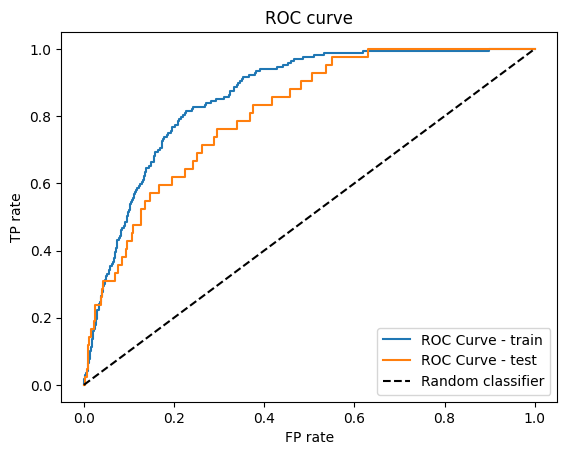

In [42]:

param_grid = {
    "modelo__C" :np.geomspace(1e-20,1e+2,100)
}
pipe = Pipeline([('escala',MinMaxScaler()),('modelo', LogisticRegression(penalty='l2',class_weight='balanced',max_iter=1000000))])

search = GridSearchCV(pipe, param_grid,scoring = my_scorer, cv = 3, n_jobs=-1)
search.fit(X_train, y_train)
bests = search.best_estimator_

print("--melhor escore no cv--")
print(search.best_score_)

print("--parâmetros de melhor escore no cv--") 
print(search.best_params_)


y_pred_test = bests.decision_function(X_test)
y_pred_train = bests.decision_function(X_train)

fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
distances = (fpr - 0)**2 + (tpr - 1)**2
index = distances.argmin()
best_threshold = thresholds[index]
fprts, tprts, thresholdsts = roc_curve(y_test, y_pred_test)
print("Ponto mais próximo do canto superior esquerdo:")
print("FPR:", fpr[index])
print("TPR:", tpr[index])
print("Limiar:", best_threshold)


corte = best_threshold
print("--minha métrica--")
print(minha_metrica_c(y_train,y_pred_train,corte),minha_metrica_c(y_test,y_pred_test,corte))
print("--acuracia--")
print(accuracy_score(y_train,y_pred_train>=corte),accuracy_score(y_test,y_pred_test>=corte))
print("--confusion matriz--")
print(confusion_matrix(y_pred=y_pred_test>=corte,y_true=y_test))

plt.plot(fpr, tpr, label='ROC Curve - train')
plt.plot(fprts, tprts, label='ROC Curve - test')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()


In [44]:
bests.named_steps['modelo'].coef_

array([[4.01856492, 0.87061881, 0.56038468, 0.1570624 , 0.15277755,
        0.94473208, 0.11344601]])

In [45]:
X.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'avg_glucose_level', 'smoking_status'],
      dtype='object')

In [1]:

print("roc_auc_score", roc_auc_score(y_train,y_pred_train>=corte),roc_auc_score(y_test,y_pred_test))
print("accuracy_score", accuracy_score(y_train,y_pred_train>=corte),accuracy_score(y_test,y_pred_test>=corte))
print("precision_score", precision_score(y_train,y_pred_train>=corte),precision_score(y_test,y_pred_test>=corte))
print("recall_score", recall_score(y_train,y_pred_train>=corte),recall_score(y_test,y_pred_test>=corte))
print("f1_score",f1_score(y_train,y_pred_train>=corte),f1_score(y_test,y_pred_test>=corte))


NameError: name 'roc_auc_score' is not defined

--melhor escore no cv--
0.7849872374350468
--parâmetros de melhor escore no cv--
{'modelo__degree': 1, 'modelo__gamma': 100.0}
Ponto mais próximo do canto superior esquerdo:
FPR: 0.225531914893617
TPR: 0.8143712574850299
Limiar: 0.15286769222426955
--minha métrica--
0.7941690930463791 0.6798965890735442
--acuracia--
0.7761650114591291 0.7688391038696538
--confusion matriz--
[[730 210]
 [ 17  25]]


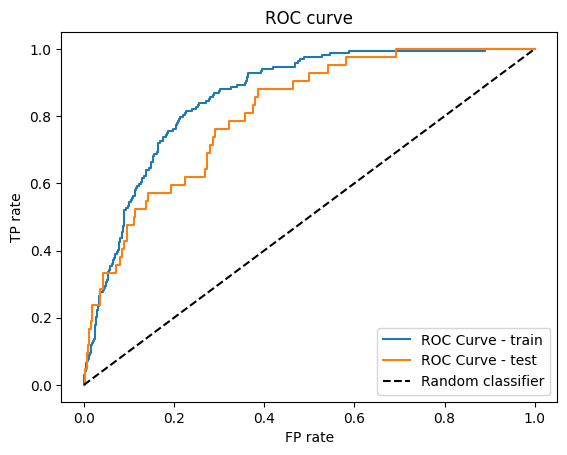

In [36]:

param_grid = {
    # "modelo__nu" :np.linspace(0.01,0.99,10),
    "modelo__gamma" :np.geomspace(1e-1,1e+2,5),
    "modelo__degree":[1,2]
}

# pipe = Pipeline([('escala',MinMaxScaler()),('modelo', NuSVC(kernel='poly'))])

pipe = Pipeline([('escala',MinMaxScaler()),('modelo', SVC(kernel='poly',class_weight='balanced'))])


search = GridSearchCV(pipe, param_grid, scoring = my_scorer, cv = 3, n_jobs=-1)
search.fit(X_train, y_train)
bests = search.best_estimator_

print("--melhor escore no cv--")
print(search.best_score_)

print("--parâmetros de melhor escore no cv--") 
print(search.best_params_)


y_pred_test = bests.decision_function(X_test)
y_pred_train = bests.decision_function(X_train)

fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
distances = (fpr - 0)**2 + (tpr - 1)**2
index = distances.argmin()
best_threshold = thresholds[index]
fprts, tprts, thresholdsts = roc_curve(y_test, y_pred_test)
print("Ponto mais próximo do canto superior esquerdo:")
print("FPR:", fpr[index])
print("TPR:", tpr[index])
print("Limiar:", best_threshold)


corte = best_threshold
print("--minha métrica--")
print(minha_metrica_c(y_train,y_pred_train,corte),minha_metrica_c(y_test,y_pred_test,corte))
print("--acuracia--")
print(accuracy_score(y_train,y_pred_train>=corte),accuracy_score(y_test,y_pred_test>=corte))
print("--confusion matriz--")
print(confusion_matrix(y_pred=y_pred_test>=corte,y_true=y_test))

plt.plot(fpr, tpr, label='ROC Curve - train')
plt.plot(fprts, tprts, label='ROC Curve - test')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [38]:
print("roc_auc_score", roc_auc_score(y_train,y_pred_train),roc_auc_score(y_test,y_pred_test))
print("accuracy_score", accuracy_score(y_train,y_pred_train>=corte),accuracy_score(y_test,y_pred_test>=corte))
print("precision_score", precision_score(y_train,y_pred_train>=corte),precision_score(y_test,y_pred_test>=corte))
print("recall_score", recall_score(y_train,y_pred_train>=corte),recall_score(y_test,y_pred_test>=corte))
print("f1_score",f1_score(y_train,y_pred_train>=corte),f1_score(y_test,y_pred_test>=corte))


roc_auc_score 0.8602306026245382 0.8101823708206687
accuracy_score 0.7761650114591291 0.7688391038696538
precision_score 0.13821138211382114 0.10638297872340426
recall_score 0.8143712574850299 0.5952380952380952
f1_score 0.23631624674196353 0.18050541516245489


--melhor escore no cv--
0.7873867789076551
--parâmetros de melhor escore no cv--
{'modelo__max_features': 'log2', 'modelo__n_estimators': 15}
Ponto mais próximo do canto superior esquerdo:
FPR: 0.18882978723404256
TPR: 0.7904191616766467
Limiar: 0.567062300137469
--minha métrica--
0.8007274689627771 0.6973680437544066
--acuracia--
0.810287751464222 0.8075356415478615
--roc_score--
0.8007946872213021 0.70612968591692
--confusion matriz--
[[768 172]
 [ 17  25]]


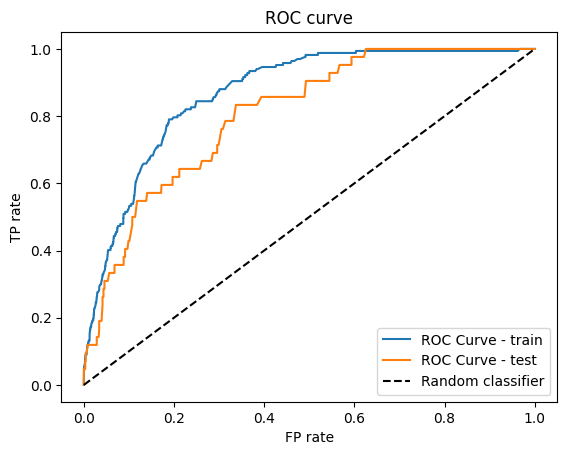

In [40]:
# balancear = SMOTE()

# X_resampled, y_resampled = balancear.fit_resample(X_train, y_train)

# my_scorer = make_scorer(roc_auc_score,greater_is_better=True)

param_grid = {
    'modelo__n_estimators': [2*n+1 for n in range(5,50)],
    'modelo__max_features':["sqrt", "log2"]
    }

pipe = Pipeline([('modelo', RandomForestClassifier(class_weight='balanced',max_depth=3))])

search = GridSearchCV(pipe, param_grid, scoring = my_scorer, cv = 3, n_jobs=-1)
search.fit(X_train, y_train)
bests = search.best_estimator_

print("--melhor escore no cv--")
print(search.best_score_)

print("--parâmetros de melhor escore no cv--") 
print(search.best_params_)


y_pred_test = bests.predict_proba(X_test)[:,1]
y_pred_train = bests.predict_proba(X_train)[:,1]

fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
distances = (fpr - 0)**2 + (tpr - 1)**2
index = distances.argmin()
best_threshold = thresholds[index]
fprts, tprts, thresholdsts = roc_curve(y_test, y_pred_test)
print("Ponto mais próximo do canto superior esquerdo:")
print("FPR:", fpr[index])
print("TPR:", tpr[index])
print("Limiar:", best_threshold)


corte = best_threshold
print("--minha métrica--")
print(minha_metrica_c(y_train,y_pred_train,corte),minha_metrica_c(y_test,y_pred_test,corte))
print("--acuracia--")
print(accuracy_score(y_train,y_pred_train>=corte),accuracy_score(y_test,y_pred_test>=corte))
print("--roc_score--")
print(roc_auc_score(y_train,y_pred_train>=corte),roc_auc_score(y_test,y_pred_test>=corte))
print("--confusion matriz--")
print(confusion_matrix(y_pred=y_pred_test>=corte,y_true=y_test))

plt.plot(fpr, tpr, label='ROC Curve - train')
plt.plot(fprts, tprts, label='ROC Curve - test')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [41]:
print("roc_auc_score", roc_auc_score(y_train,y_pred_train),roc_auc_score(y_test,y_pred_test))
print("accuracy_score", accuracy_score(y_train,y_pred_train>=corte),accuracy_score(y_test,y_pred_test>=corte))
print("precision_score", precision_score(y_train,y_pred_train>=corte),precision_score(y_test,y_pred_test>=corte))
print("recall_score", recall_score(y_train,y_pred_train>=corte),recall_score(y_test,y_pred_test>=corte))
print("f1_score",f1_score(y_train,y_pred_train>=corte),f1_score(y_test,y_pred_test>=corte))

roc_auc_score 0.8689323480698179 0.8068389057750759
accuracy_score 0.810287751464222 0.8075356415478615
precision_score 0.15676959619952494 0.12690355329949238
recall_score 0.7904191616766467 0.5952380952380952
f1_score 0.2616451932606541 0.2092050209205021


In [8]:
bests

Pipeline(steps=[('modelo',
                 RandomForestClassifier(class_weight='balanced', max_depth=3,
                                        max_features='log2',
                                        n_estimators=31))])

In [ ]:
search.cv_results_['params']

In [ ]:
mean_scores = search.cv_results_['mean_test_score']
params = search.cv_results_['params']

# Encontrar os valores médios dos scores para as combinações desejadas
for mean_score, param in zip(mean_scores, params):
    if param['modelo__max_features'] == 'sqrt':
        print("modelo__n_estimators:", param['modelo__n_estimators'])
        print("Score médio:", mean_score)
        print()